In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('../Datasets/nonlinear_diffusion.mat')
u = real(data['usol'])
x = real(data['x'][0])
t = real(data['t'][0])
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

x, t

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
        1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
        1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
        1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
        1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ,
        2.025, 2.05 , 2.075, 2.1  , 2.125, 2.15 , 2.175, 2.2  , 2.225,
        2.25 , 2.275, 2.3  , 2.325, 2.35 , 2.375, 2.4  , 2.425, 2.45 ,
        2.475, 2.5  , 2.525, 2.55 , 2.575, 2.6  , 2.625, 2.65 , 2.675,
        2.7  , 2.725, 2.75 , 2.775, 2.8  , 2.825, 2.85 , 2.875, 2.9  ,
        2.925, 2.95 , 2.975, 3.   , 3.025, 3.05 , 3.075, 3.1  , 3.125,
      

cmap = viridis


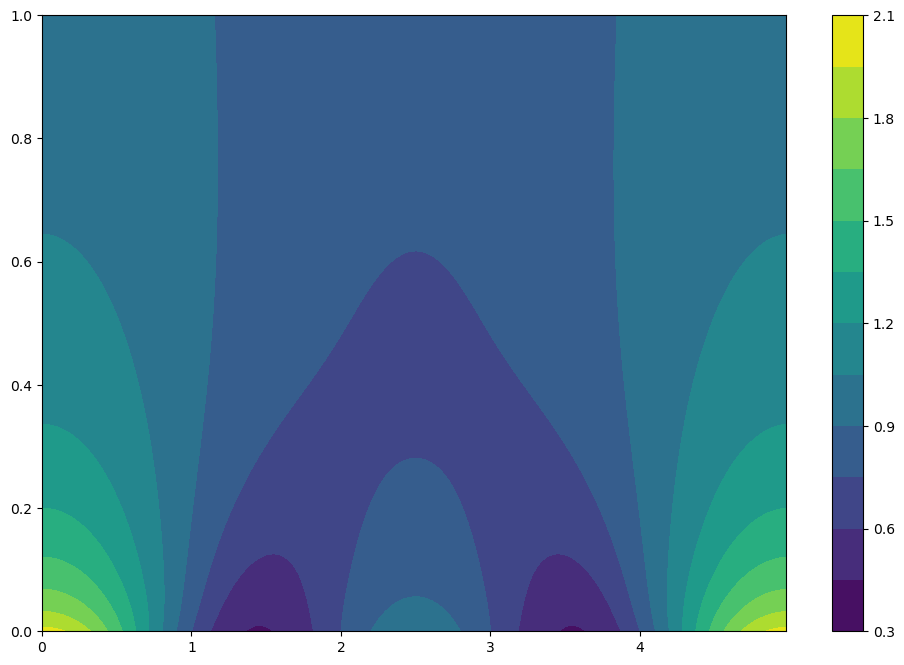

In [3]:
from matplotlib import cm
cmap_name = cm.get_cmap().name
print("cmap =", cmap_name)

plt.contourf(X, T, u.T, levels=10, cmap=cmap_name)
plt.colorbar()
plt.show()

In [4]:
np.random.seed(0)
noise_lv = float(7)
noise = 0.01*np.abs(noise_lv)*std(u)*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
un = np.expand_dims(un, -1)

In [5]:
diff_order = 2; K = 10000
differentiation_method = ps.FiniteDifference
differentiation_kwargs = {}
n_times = 1

datasets = []
for step in trange(n_times):
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                     function_names=[lambda x: x, lambda x: x + x], 
                                     derivative_order=diff_order, 
                                     spatiotemporal_grid=XT, 
                                     include_bias=False, is_uniform=True, K=K, 
                                     differentiation_method=differentiation_method, 
                                     differentiation_kwargs=differentiation_kwargs, 
                                     cache=False
                                    )
    X_weak = weak_pde_lib.fit_transform(un).reshape(-1, len(weak_pde_lib.get_feature_names()))
    y_weak = weak_pde_lib.convert_u_dot_integral(un)
    datasets.append((X_weak, y_weak))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.63s/it]


In [6]:
X_weak_mean = np.array([X_weak for X_weak, _ in datasets]).mean(axis=0)
y_weak_mean = np.array([y_weak for _, y_weak in datasets]).mean(axis=0)

In [7]:
max_complexity = 10

In [8]:
bnb_sols = bnb(X_weak_mean, y_weak_mean, max_nonzeros=max_complexity, lam=1e-3, corrected_coefficients=True)
bnb_feature_hierarchy = set([tuple(np.nonzero(bnb_sols[:, i:i+1].flatten())[0].tolist()) 
                             for i in range(bnb_sols.shape[1])])
bnb_feature_hierarchy

{(0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 2, 3, 5, 6, 7), (0, 6), (6,)}

In [9]:
frols_coeffs,selected_inds_list,_,_,_ = frols(y_weak_mean,X_weak_mean,max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 6, 7),
 (0, 1, 3, 6),
 (0, 1, 3, 6, 7),
 (0, 1, 6),
 (0, 6),
 (6,)}

In [10]:
feature_hierarchy = bnb_feature_hierarchy.union(selected_inds_list)

In [11]:
br1 = backward_refinement(feature_hierarchy, (X_weak_mean,y_weak_mean), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (X_weak_mean,y_weak_mean), mode='k best', ic_type='bic', verbose=True)
br=br1+br2
br

RFE_PLinearRegression
(0, 1, 6)
(0, 6)
(6,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 6, 7)
(0, 1, 3, 6, 7)
(0, 1, 3, 7)
(0, 1, 3)
(1, 3)
(3,)
--------------------------------------------------
(0, 1, 2, 3, 4, 6, 7)
--------------------------------------------------
(0, 6)
--------------------------------------------------
(0, 1, 2, 3, 5, 6, 7)
(0, 1, 2, 3, 6, 7)
--------------------------------------------------
(0, 1, 3, 6, 7)
--------------------------------------------------
(0, 1, 3, 6)
(0, 1, 6)
--------------------------------------------------
(0, 1, 2, 3, 6, 7)
--------------------------------------------------
SelectKBest
(0, 1, 6)
(0, 6)
(6,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 6, 7)
(0, 1, 3, 6, 7)
(0, 1, 3, 7)
(0, 1, 3)
(1, 3)
(3,)
--------------------------------------------------
(0, 1, 2, 3, 4, 6, 7)
----------------------------

{1: ((6,), -101077.15356578214), 2: ((0, 6), -105275.54729477703), 3: ((0, 1, 6), -107589.49439851158), 4: ((0, 1, 3, 7), -108173.5954215682), 5: ((0, 1, 3, 6, 7), -108186.74806661191), 6: ((0, 1, 2, 3, 6, 7), -108181.25705039898), 7: ((0, 1, 2, 3, 4, 6, 7), -108182.42898935443), 8: ((0, 1, 2, 3, 4, 5, 6, 7), -108173.23903614844)}

In [12]:
[convert2latex(e.replace('x0', 'u').replace("uf", "u").replace('*', '')) for i,e in enumerate(weak_pde_lib.get_feature_names())]

['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']

In [13]:
complexities = np.array(sorted(list(br.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br.track[com]
    bic_scores.append(bic)
    # eff_feature_name = [e for i,e in enumerate(weak_pde_lib.get_feature_names()) if i in indices]
    # print(eff_feature_name)
    eff_feature_name = [convert2latex(e.replace('x0', 'u').replace("uf", "u").replace('*', '')) for i,e in enumerate(weak_pde_lib.get_feature_names()) if i in indices]
    eff_feature_names.append(f"$[{', '.join(eff_feature_name)}]$")
    print(indices, bic)
bic_scores = np.array(bic_scores)
rel_bic_scores = (bic_scores-np.min(bic_scores))/1e3

(6,) -101077.15356578214
(0, 6) -105275.54729477703
(0, 1, 6) -107589.49439851158
(0, 1, 3, 7) -108173.5954215682
(0, 1, 3, 6, 7) -108186.74806661191
(0, 1, 2, 3, 6, 7) -108181.25705039898
(0, 1, 2, 3, 4, 6, 7) -108182.42898935443
(0, 1, 2, 3, 4, 5, 6, 7) -108173.23903614844


In [14]:
index = br.track[1][0][0]
c = np.linalg.lstsq(X_weak_mean[:, index:index+1], y_weak_mean, rcond=None)[0].flatten()[0]

In [15]:
# moving to what index and what percent gained
def check_percent(bic_scores, complexities):
    slope = (bic_scores[1:]-bic_scores[:-1])/(complexities[1:]-complexities[:-1])
    slope_index = np.argmin(slope)
    percent_improve = 100*np.abs(bic_scores[slope_index+1]-bic_scores[slope_index])/np.abs(bic_scores[slope_index])
    percent_from_1 = 100*np.abs(bic_scores[slope_index+1]-bic_scores[0])/np.abs(bic_scores[0])
    return slope_index+1, percent_improve, percent_from_1

In [16]:
ii, per1, per2 = check_percent(bic_scores, complexities)
print(ii, per1, per2)
print(complexities[ii])

1 4.153652512842612 4.153652512842612
2


In [17]:
label=f'''Improves {format(per2, '.2f')}\% from $u_t={format(c, '.2f')}uu_{{xx}}$'''

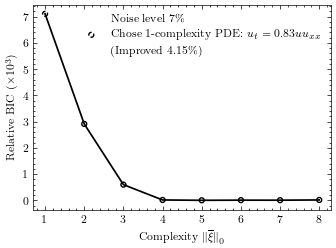

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
FT = 8
plt.rcParams.update({'font.size': FT})

with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot([], [], ' ', label=f"Noise level {int(noise_lv)}\%")
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5/2)
    ax.scatter(complexities[:1], rel_bic_scores[:1], marker='o', linestyle='--', fc='none', ec='black', s=25/2, label=f'''Chose 1-complexity PDE: $u_t={format(c, '.2f')}uu_{{xx}}$''')
    ax.scatter(complexities[1:], rel_bic_scores[1:], marker='o', fc='none', ec='black', s=25/2)
    ax.plot([], [], ' ', label=f'''(Improved {format(per2, '.2f')}\%)''')
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)", fontsize=FT)
    plt.xlabel(r"Complexity $\lVert\overline{\xi}\rVert^{}_{0}$", fontsize=FT)
    plt.tight_layout()
    plt.xticks([i for i in range(min(complexities), max(complexities)+1)])
    plt.legend(loc='upper right', fontsize=FT)
    # plt.savefig('./visualization/vis_pics/1Term.pdf')
    plt.show()

In [19]:
# 2 does not improve 1
# Percent improve: 0.04153652512842612
# OK!
d_bic_scores, d_complexities, _ = get_decreasing_vals(bic_scores, complexities)
if find_transition_V5(d_bic_scores, d_complexities, 0.09, 0.01) == 1: print('OK!')

2 does not improve 1
Percent improve: 0.04153652512842612
OK!


In [20]:
# 1, 5, 10, 15 ?
# 10 or 15 are good choices

In [21]:
(1-c)*100

17.171719528501995

In [22]:
# 1term: 17.171719528501995

# NV: 15.590001029825158, 15.529212575624166

# 2d
# u, v
# 3.1176646941363617 1.0275748708131187
# 3.3250884079139156 1.2489754144067837

# 3d 128
# u, v
# 0.04903734758057313 0.0720098613077069
# 0.007095281555447451 0.007249215450554728

# 3d 64
# u, v
# 0.08588200850846384 0.0973849324665898
# 0.05842282826471952 0.03375502859786496